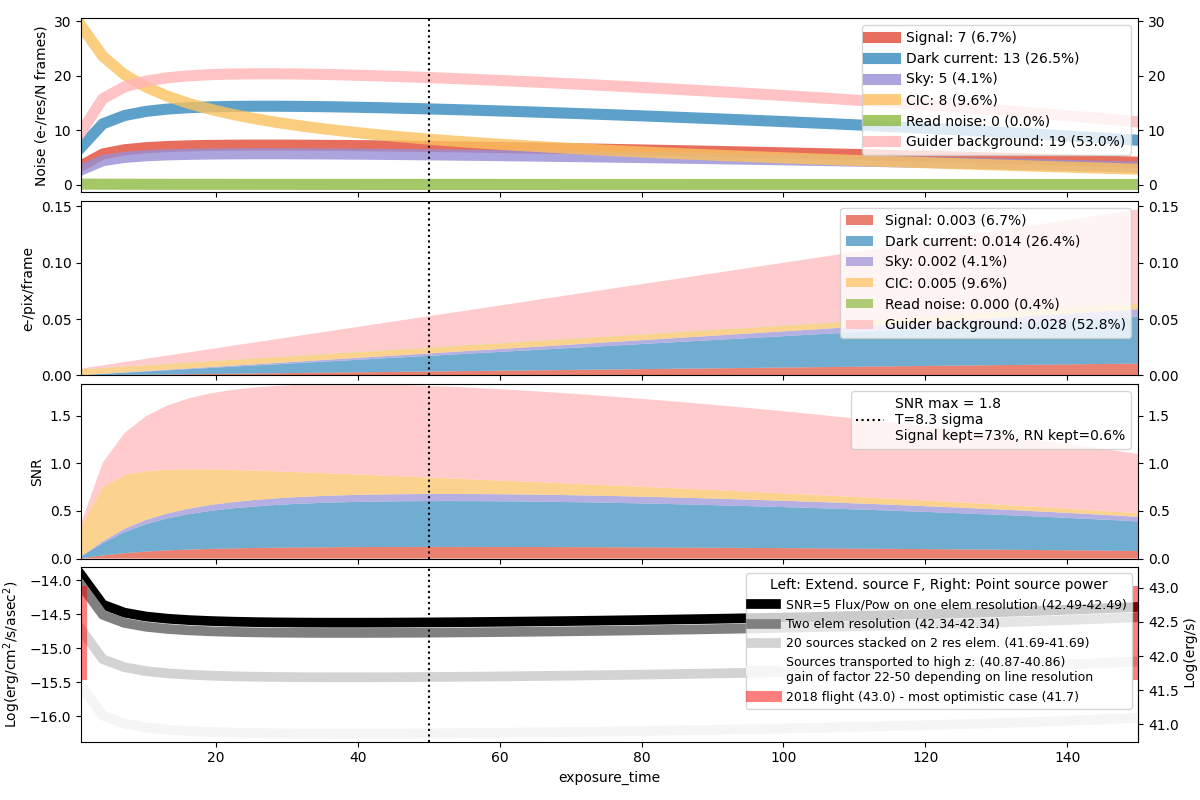

In [5]:
%matplotlib widget
%reload_ext autoreload

from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
from scipy.interpolate import interpn
# plt.style.use('dark_background')
import functools
np.seterr(invalid='ignore')

def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))



def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    # names, varargs, keywords, defaults = inspect.getargspec(func)
    names, varargs, keywords, defaults,_,_,_ = inspect.getfullargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper


# Initialization of the thresholding functions. So that files are not read several times
n=10
type_="" #"new_" #""
#new is for when we don't use fraction and use RN (false I think), "" is with fraction true positives and RN/gain, seems better 
table_threshold = fits.open("%sthreshold_%s.fits"%(type_,n))[0].data
table_snr = fits.open("%ssnr_max_%s.fits"%(type_,n))[0].data
table_fraction_rn = fits.open("%sfraction_rn_%s.fits"%(type_,n))[0].data
table_fraction_flux = fits.open("%sfraction_flux_%s.fits"%(type_,n))[0].data

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   

class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=24, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, guider_noise = 0,acquisition_time = 2,smearing=0,i=0,plot_=False,temperature=-100,n=n,PSF_RMS_mask=5, PSF_RMS_det=8, QE = 0.45,cosmic_ray_loss_per_sec=0.005):#,photon_kept=0.7#, flight_background_damping = 0.9
        """
        ETC calculator: computes the noise budget at the detector level based on instrument/detector parameters
        This is currently optimized for slit spectrographs and EMCCD but could be pretty easily generalized to other instrument type if needed
        """
        wavelength=2000
        if Signal>1:
            # actually here we should ask the size of the source
            # if the source extension is >> FWHM insturment, then flux is this
            # if compact or << FWHM then Flux must be divided by the PSF profile (~7)
            # if it is around the FWHM then the flux is lowered by <7
            # there fore the e-/pix value will be the max value.
            self.Signal = 10**(-(Signal-20.08)/2.5)*2.06*1E-16
        # throughput = 0.13*0.9
        # atm = 0.45
        # detector = 0.45
        self.area = 7854
        self.dispersion = 46.6/10
        # elec_pix = flux * throughput * atm * detector * area /dispersion# should not be multiplied by exposure time here

        self.pixel_size = 13 # microns  #Chase=15mu
        self.resolution_element= self.PSF_RMS_det * 2.35 * self.pixel_size #57#microns
        #Cut by the slit: computed by table in:
        # Fraction lost by the slit: https://articles.adsabs.harvard.edu//full/1961SvA.....4..841B/0000844.000.html
        # S=3'' in our case, with sigma_mask  1.27 , then wer fit: #plt.plot([0.1,0.2,0.4,0.7,1,1.5,2,2.5,3],[1.000,1.000,1.000,1.000,0.997,0.955,0.866,0.770,0.683],"o")
        self.PSF_loss_slit_function = np.poly1d([-0.1824,  1.2289]) #for 6" slit, 3" half size
        self.flux_fraction_slit = np.minimum(1,self.PSF_loss_slit_function(self.PSF_RMS_mask))

        self.Throughput = 0.13 * 0.9 # Because of siderostat loss...#0.15 - 0.2 chase
        self.Atmosphere = 0.5 #? Chase
        self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']

        self.ENF = 1 if self.counting_mode else 2 # Excess Noise Factor 
        self.CIC_noise = np.sqrt(CIC_charge * self.ENF) 
        self.Dark_current_f = self.Dard_current * self.exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f * self.ENF)
        
        self.lu2ergs = 2.33E-19/1000        
        self.Sky_ = self.Sky_LU*self.lu2ergs# ergs/cm2/s/arcsec^2 
        
        #for now we put the regular QE without taking into account the photon kept fracton, because then infinite loop. Two methods to compute it: interpolate_optimal_threshold & compute_optimal_threshold
        if counting_mode:
            self.factor_el = self.QE * self.Throughput * self.Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
            self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky * self.ENF) 
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.interpolate_optimal_threshold(plot_=plot_, i=i)
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = np.zeros(50),np.ones(50),np.ones(50), np.zeros(50) #0,1,1, 0
            # self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        # The faction of detector lost by cosmic ray masking (taking into account ~5-10 impact per seconds and around 2000 pixels loss per impact (0.01%))
        self.cosmic_ray_loss = np.minimum(self.cosmic_ray_loss_per_sec*(self.exposure_time+self.readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * self.QE

        self.factor_el = self.QE_efficiency * self.Throughput * self.Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = self.Sky_LU*self.factor_el*self.exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * self.EM_gain #* Gain_ADU  # ADU/pix/frame
        self.Sky_noise = np.sqrt(self.sky * self.ENF) 
            

        self.RN_final = self.RN  * self.RN_fraction_kept / self.EM_gain #Are we sure about that? 
        self.Additional_background = guider_noise/3600 * self.exposure_time# e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background * self.ENF)
        
        # number of images taken during one field acquisition (~2h)
        self.N_images = self.acquisition_time*3600/(self.exposure_time + self.readout_time)
        coeff_stack = 1 #TBC, why was this set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.Signal_LU = self.Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el =  self.Signal_LU*self.factor_el*self.exposure_time * self.flux_fraction_slit  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (self.resolution_element/self.pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el * self.ENF )     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *self.resolution_element/self.pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise_resol *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (self.resolution_element/self.pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (self.resolution_element/self.pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:#to correct
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution","Signal_el","sky","CIC_charge","Dark_current_f","RN","Additional_background"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        # self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final]).T
        
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Additional_background_noise*self.factor, self.Signal_resolution]).T
        self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final,self.Additional_background]).T
        self.names = ["Signal","Dark current", "Sky", "CIC", "Read noise","Guider background"]
        
        self.snrs=self.Signal_resolution /self.Total_noise_final
        if np.ndim(self.noises)==2:
            self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        else:
            self.percents =  100* np.array(self.noises).T[:-1]**2/self.Total_noise_final**2            
        self.el_per_pix = self.Signal_el + self.sky + self.CIC_charge +  self.Dark_current_f
        n_sigma = 5
        self.signal_nsig_e_resol_nframe = (n_sigma**2 * self.ENF + n_sigma**2 * np.sqrt(4*self.Total_noise_final**2 - 4*self.signal_noise_nframe**2 + self.ENF**2*n_sigma**2))/2
        self.signal_nsig_LU = self.signal_nsig_e_resol_nframe * self.eresolnframe2lu
        self.signal_nsig_ergs = self.signal_nsig_LU * self.lu2ergs
        self.extended_source_5s = self.signal_nsig_ergs * (1.1*self.PSF_RMS_det)**2
        self.point_source_5s = self.extended_source_5s * 1.30e57

       

    def PlotNoise(self,title='',x='exposure_time', lw=8):
        """
        Generate a plot of the evolution of the noise budget with one parameter:
        exposure_time, Sky_LU, acquisition_time, Signal, EM_gain, RN, CIC_charge, Dard_current, readout_time, smearing, temperature, PSF_RMS_det, PSF_RMS_mask, QE, guider_noise, cosmic_ray_loss_per_sec
        """
        fig, axes= plt.subplots(4, 1, figsize=(12, 8), sharex=True) # fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True) #figsize=(9, 5.5)
        ax1, ax2,ax3, ax4  = axes
        labels = ['%s: %0.3f (%0.1f%%)'%(name,getattr(self,"electrons_per_pix")[self.i,j],100*getattr(self,"electrons_per_pix")[self.i,j]/np.sum(getattr(self,'electrons_per_pix')[self.i,:])) for j,name in enumerate(self.names)]

        # ax1 
        for i,(name,c) in enumerate(zip(self.names,self.colors)):
            ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Noise (e-/res/N frames)')

        # ax2 
        ax2.grid(False)
        ax2.stackplot(getattr(self,x),  np.array(self.electrons_per_pix).T[:,:],alpha=0.7,colors=self.colors,labels=labels)
        ax2.set_ylabel('e-/pix/frame')
        ax2.legend(loc='upper right')
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))

        # ax3
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=self.colors)
        ax3.set_ylim((0,np.max(self.SNR)))
        ax3.set_ylabel('SNR')        

        # ax4
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s),"-",lw=lw-1,label="SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]),np.nanmin(np.log10(self.point_source_5s))),c="k")
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)),"-",lw=lw-1,label="Two elem resolution (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)))),c="grey")
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(40)),"-",lw=lw-1,label="20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(self.point_source_5s[self.i]/np.sqrt(40)),np.nanmin(np.log10(self.point_source_5s/np.sqrt(40)))),c="lightgrey")
        ax4.plot(getattr(self,x), np.log10(self.extended_source_5s/np.sqrt(2)/30),"-",lw=lw-1,label="Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(self.point_source_5s[self.i]/np.sqrt(2)/30),np.nanmin(np.log10(self.point_source_5s/np.sqrt(2)/30))),c="whitesmoke")
        T2 =  lambda x:np.log10(10**x/1.30e57)
        self.pow_2018 = 42.95
        self.pow_best = 41.74
        ax4b = ax4.secondary_yaxis("right", functions=(lambda x:np.log10(10**x * 1.30e57),T2))
        ax4.plot([getattr(self,x).min(),getattr(self,x).min(),np.nan,getattr(self,x).max(),getattr(self,x).max()],[T2(self.pow_2018),T2(self.pow_best),np.nan,T2(self.pow_2018),T2(self.pow_best)],lw=lw,label="2018 flight (%0.1f) - most optimistic case (%0.1f)"%(self.pow_2018,self.pow_best),c="r",alpha=0.5)
        self.T2=T2
        self.ax4b = ax4b
        ax4.legend(loc="upper right", fontsize=9,title="Left: Extend. source F, Right: Point source power" )
        ax4.set_ylabel(r"Log(erg/cm$^2$/s/asec$^2$)")
        ax4b.set_ylabel(r" Log(erg/s)")

        axes[-1].set_xlabel(x)
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)
        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout(h_pad=0.01)
        return fig 

    
    def compute_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0,axes=None,size= (int(1e3),int(1e3)),size_bin=25, threshold=-1000):
        """ 
        Create a ADU value histogram and defin the threshold so that it gives the optimal SNR based on RN, smearing, noise, flux, gain
        Function is pretty slow so output of this function has been saved and can then directly be used with interpolation (see function interpolate_optimal_threshold)
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN = self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        bins = np.arange(np.min(imaADU)-5*RN*ConversionGain,np.max(imaADU)+5*RN*ConversionGain,25)
        # bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        if plot_:
            if axes is None:
                fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(12, 7))#,figsize=(9,5))
            else:
                fig=0
                ax1, ax2 = axes
                ax1.clear()
                ax2.clear()
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4)
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size))

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_frac = np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) 
        rn_noise = (RN/(Emgain * ConversionGain)) * rn_frac #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        # rn_noise = RN * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc = np.ones(len(b))# 
              # ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))

        if dark_cic_sky_noise is None:
            noise = CIC_noise**2+dark_noise**2+Sky_noise**2
        else:
            noise = dark_cic_sky_noise
        # print('noises = ',noise)
        SNR1 = pc*signal1/np.sqrt(signal1+noise)#+np.array(rn_noise)**2
        SNR12 = pc*signal12/ np.sqrt(signal12+noise+np.array(rn_noise)**2)
        SNR_analogic = flux/np.sqrt(2*flux+2*noise+(RN/(Emgain * ConversionGain))**2)
        # print('SNR_analogic = ',SNR_analogic)
        threshold_55 = 5.5*RN*ConversionGain
        id_55 =  np.argmin(abs(threshold_55 - b))
        if threshold<-5:
            id_t = np.nanargmax(SNR1)
            threshold = b[id_t]
        else:
            threshold *= RN*ConversionGain
            id_t = np.argmin(abs(threshold - b))
        # print(threshold)
        fraction_signal = np.sum(val1[id_t:])/np.sum(val1)
        fraction_rn = np.sum(val0[id_t:])/np.sum(val0)
        lw=3
        if plot_:
            ax2.plot(b,signal1/flux,label='Signal(Signal>T):  %0.1f%% ➛ %0.1f%%'%(100*signal1[id_55]/flux,100*signal1[id_t]/flux),lw=lw)
            ax2.plot(b,rn_frac,label='RN(RN>T):  %0.2f%% ➛ %0.2f%%'%(100*rn_frac[id_55],100*rn_frac[id_t]),lw=lw)
            # ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2',lw=lw)
            ax2.plot(b,pc,label='Fraction(T) of true positive: %0.1f%% ➛ %0.1f%%'%(100*pc[id_55],100*pc[id_t]),lw=lw)
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')

            ax2.plot(b,SNR1/SNR1.max(),label='SNR1: %0.2f%% ➛ %0.2f%%'%(SNR1[id_55],SNR1[id_t]),lw=lw) #'%(100*np.sum(val0[id_t:])/np.sum(val0),100*np.sum(val1[id_t:])/np.sum(val1)),lw=lw)
            # ax2.plot(b,SNR12,':',label='SNR12, [N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))),lw=lw)
            ax2.plot(b,SNR1/SNR_analogic,label='SNR1 PC / SNR analogic: %0.2f ➛ %0.2f'%(SNR1[id_55]/SNR_analogic,SNR1[id_t]/SNR_analogic),lw=lw)
            # ax2.plot(b,SNR12/SNR_analogic,':',label='SNR12 PC / SNR analogic',lw=lw)
            # ax2.set_yscale('log')
            ax2.set_ylim(ymin=1e-5)
            
            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[id_t]/val0[id_t],100*np.sum(val1[id_t:])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend(fontsize=10)
            ax2.legend(title = "T = 5.5σ ➛ %0.1fσ "%(threshold/(RN*ConversionGain)), fontsize=10)
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[id_t:])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[id_t:])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[id_t:])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,1],':',c='k')
            ax1.plot([threshold_55,threshold_55],[0,np.max(val0)],'-.',c='k')
            ax2.plot([threshold_55,threshold_55],[0,1],'-.',c='k')

            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)#bins.max())
            if axes is None:
                fig.tight_layout()
            return fig
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn, np.nanmax(SNR1/SNR_analogic)
 


    def interpolate_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0):
        """
        Return the threshold optimizing the SNR
        """
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain #if np.isscalar(self.EM_gain) else self.EM_gain[i]
        RN= self.RN #if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise #if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise #if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding #if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        noise_value = CIC_noise**2+dark_noise**2+Sky_noise**2
        
        gains=np.linspace(800,2500,self.n)
        rons=np.linspace(30,120,self.n)
        fluxes=np.linspace(0.01,0.7,self.n)
        smearings=np.linspace(0,2,self.n)
        noise=np.linspace(0.002,0.05,self.n)
        if (n==6)|(n==10):
            coords = (gains, rons, fluxes, smearings)
            point = (Emgain, RN, flux, self.smearing)            
        elif n==5:
            coords = (gains, rons, fluxes, smearings,noise)
            point = (Emgain, RN, flux, self.smearing,noise_value)
            
        if ~np.isscalar(noise_value) |  ~np.isscalar(self.smearing) | ~np.isscalar(Emgain) | ~np.isscalar(RN):
            point = np.repeat(np.zeros((4,1)), 50, axis=1).T
            point[:,0] =  self.EM_gain
            point[:,1] = self.RN
            point[:,2] = flux
            point[:,3] = self.smearing
        fraction_rn =interpn(coords, table_fraction_rn, point,bounds_error=False,fill_value=None)
        fraction_signal =interpn(coords, table_fraction_flux, point,bounds_error=False,fill_value=None)
        threshold = interpn(coords, table_threshold, point,bounds_error=False,fill_value=None)
        snr_ratio = interpn(coords, table_snr, point,bounds_error=False,fill_value=None)
        return threshold, fraction_signal, fraction_rn, snr_ratio#np.nanmax(SNR1/SNR_analogic)
 

class ExposureTimeCalulator(widgets.HBox):
    def __init__(self, follow_temp=False, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=24, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,guider_noise=0,temperature=-100,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005):
        """
        Generate an ETC app containing multiple widghet that allow to change the ETC parameters
        as well as plotting the result (e- and noise budget, limiting flux, SNR) in terms of the different parameters.
        """
        super().__init__()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())

        self.output = widgets.Output()
        self.guider_noise=guider_noise
        time=np.linspace(1,150)
        i = np.argmin(abs(time - exposure_time))
        self.follow_temp=follow_temp
        # Dard_current = 10**np.poly1d([0.07127906, 6.83562573])(np.linspace(-110,-80))
        # smearing = np.poly1d([-0.0306087, -2.2226087])(np.linspace(-110,-80))

        Nominal = Observation(exposure_time=time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec)#,cosmic_ray_loss=0.25)
        self.Nominal=Nominal
        #flight_background_damping = 0.9, guider_noise = 0.0007
        self.x = time#Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.fig = Nominal.PlotNoise(x=x_axis)
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                try:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold[i], 100*Nominal.Photon_fraction_kept[i], 100*Nominal.RN_fraction_kept[i])
                except TypeError:
                    label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
                ax.legend(loc='upper right')
            else:
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
        self.ax3 =  self.fig.axes[3]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        small = '247px'
        small = '230px'
        psmall = '186px'
        vsmall = '147px'
        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Description', layout=Layout(width="30px")) # 'success', 'info', 'warning', 'danger' or ''
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)',description_tooltip="Single frame exposure time in seconds")
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',description_tooltip="Total acquisition time in hours")
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',description_tooltip="Level of sky background illumination in line units")#5.57e-18

        #         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 15), ('Extremely Bright QSO (mU~17)', 17), ('Bright QSO (mU~19.5)', 19.5),('Bright galaxy (mU~22.5)', 22.5), ('Regular galaxy (mU~24)', 24), ('Low SB galaxy (mU~25)', 25), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux', layout=Layout(width=small),description_tooltip="Input source flux of a diffuse object in ergs/cm2/s/arcsec^2")
        self.EM_gain = widgets.IntSlider( min=200, max=3500,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',description_tooltip="EMCCD amplification gain in e-/e-")
        self.RN = widgets.IntSlider( min=30, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',description_tooltip="EMCCD readout noise in electrons")
        self.CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',description_tooltip="EMCCD spurious charges due to amplification in electrons")

        self.fwhm = widgets.FloatRangeSlider( min=1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',description_tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
        self.QE = widgets.FloatSlider( min=0.1, max=1,value=Nominal.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',description_tooltip="EMCCD quantum efficiency in percents")
        self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',description_tooltip="Guider induced background level in electrons per hour")


        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,description_tooltip="Readout time of the EMCCD controller in seconds")
        self.follow_temp = widgets.Checkbox(value=follow_temp,description='Temp',disabled=False, layout=Layout(width=vsmall),description_tooltip="Check this box to force charge transfer efficiency and dark current levels to be fixed by the temperatuee widget. Interesting feature to optimize EMCCD temperature.")

        options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
        self.x_axis=widgets.Dropdown(options=options,value=x_axis,description='X axis', layout=Layout(width=small),description_tooltip="Variable used to analyze the evolution of the SNR.")
#         self.mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='γ-Threshold',disabled=False, layout=Layout(width=psmall),description_tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.")
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.temperature = widgets.FloatSlider( min=-120, max=-80,value=-115, style = style,description=r'Temp (C)',step=0.1, layout=Layout(width=width),description_tooltip="EMCCD's Temperature in celcius degrees: determines its charge transfer efficiency and derk current rate.")
    
        self.smearing_poly = np.poly1d([-0.0306087, -2.2226087])#np.poly1d([-0.0453913, -3.5573913])
        self.dark_poly = np.poly1d([2.13640462e-05, 7.83596239e-03, 9.57682651e-01, 3.86154296e+01])#with plateau
        self.dark_poly = np.poly1d([0.07127906, 6.83562573]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        
        self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=10**self.dark_poly(-80),value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',description_tooltip="Dark current of the EMCCD in electrons per hour. This level is fixed by the temperature when the Temp checkbock is checked.")
        self.smearing = widgets.FloatSlider( min=0, max=self.smearing_poly(-120),value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,description_tooltip="Smearing length of the EMCCD (exponential length in pixels). This length, representing the charge transfer effieciency is fixed by the temperature when the Temp checkbock is checked.")   
        self.smearing.layout.visibility = 'visible' if self.counting_mode.value  else 'hidden'
        self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
        
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,temperature=self.temperature,follow_temp=self.follow_temp,fwhm = self.fwhm,QE=self.QE, guider_noise=self.guider_noise)
        
        
        def reset(_):
            for name in ["follow_temp","exposure_time","acquisition_time","Sky_LU","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","guider_noise","temperature","QE"]:
                rsetattr(self, '%s.value'%(name), locals_[name]) 


        self.reset.on_click(reset)
        # wids = widgets.interactive(self.reset_function,reset=self.reset)
        
        if follow_temp:
            self.Dard_current.value = 10**self.dark_poly(self.temperature.value)
            self.smearing.value = self.smearing_poly(self.temperature.value)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode,self.follow_temp ,self.temperature,self.reset]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]), HBox([self.fwhm, self.guider_noise, self.QE]) ] )
            

        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        display(HBox([self.output,controls]))


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,temperature,follow_temp,fwhm,QE,guider_noise,cosmic_ray_loss_per_sec=0.005):
        """
        Update values in the ETC plot
        """
        with self.output:
            PSF_RMS_mask=fwhm[0]
            PSF_RMS_det=fwhm[1]
            names = ["Signal","Dark current","Sky", "CIC", "Read noise","Additional Background"]
                                                         
            self.smearing.layout.visibility = 'visible' if counting_mode else 'hidden'
            self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
            # options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","PSF_RMS_det","PSF_RMS_mask","QE","guider_noise","cosmic_ray_loss_per_sec"]
            if follow_temp:
                self.Dard_current.value = 10**self.dark_poly(temperature)
                self.smearing.value = self.smearing_poly(temperature)



            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            value = locals_[x_axis]

            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min, self.temperature.max)
                Dard_current = 10**self.dark_poly(temperature)
                # smearing = np.poly1d([-0.0306087, -2.2226087])(temperature)
                smearing = self.smearing_poly(temperature)
            # self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix),y=0.97)
            title = 'Gain'#=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU)
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(self.exposure_time.min,self.exposure_time.max)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(self.EM_gain.min,self.EM_gain.max)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(self.RN.min,self.RN.max)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace(self.CIC_charge.min,self.CIC_charge.max)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(self.Dard_current.min,self.Dard_current.max)
            if x_axis == 'readout_time':
                readout_time=np.linspace(self.readout_time.min,self.readout_time.max)
            if x_axis == 'smearing':
                smearing=np.linspace(self.smearing.min,self.smearing.max)

            if x_axis == 'QE':
                QE=np.linspace(self.QE.min,self.QE.max)
            if x_axis == 'PSF_RMS_mask':
                PSF_RMS_mask=np.linspace(2,8)
            if x_axis == 'PSF_RMS_det':
                PSF_RMS_det=np.linspace(2,10)
            if x_axis == 'guider_noise':
                guider_noise=np.linspace(self.guider_noise.min,self.guider_noise.max)
            if x_axis == "cosmic_ray_loss_per_sec":
                cosmic_ray_loss_per_sec=np.linspace(0.001,0.01)


            if (x_axis == 'Sky_LU') | (x_axis == 'Signal') | (x_axis == 'CIC_charge') | (x_axis == 'Dard_current'):
                self.ax0.set_xscale('log')
            else:
                self.ax0.set_xscale('linear')
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            # print('argi = ',value,arg)
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=guider_noise,i=arg,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec)
            self.colors=new.colors
            # self.ax0.set_title(title + ", e-/pix=%0.2E"%(new.el_per_pix[arg]),y=0.97)
            # self.ax0.set_title(-1)

            for v in self.v:
                v.set_xdata([value,value])
            arg = np.argmin(abs(getattr(new,x_axis) - value))
            try:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept, new.gain_thresholding)
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept)#, new.gain_thresholding)
            except TypeError:
                # label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg], new.gain_thresholding[arg])
                label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\n'%(new.SNR.max(),new.SNR[arg],new.n_threshold[arg], 100*new.Photon_fraction_kept[arg], 100*new.RN_fraction_kept[arg])#, new.gain_thresholding[arg])
                
            # self.v[0].set_label(label)
            self.v[-2].set_label(label)
            max_,min_=[],[]

            for i,name in enumerate(new.names): 
                self.ax0.lines[i].set_xdata(locals_[x_axis])
                self.ax0.lines[i].set_ydata(new.noises[:,i])
                self.ax0.lines[i].set_label('%s: %i (%0.1f%%)'%(name,new.noises[new.i,i],new.percents[i,new.i]))
                max_.append(np.nanmax(new.noises[:,i]))
                min_.append(np.nanmin(new.noises[:,i]))

                # self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                            # ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)

            self.ax0.legend(loc='upper right')

            self.ax3.set_xlabel(x_axis)
            self.ax3.lines[0].set_data(locals_[x_axis],  np.log10(new.extended_source_5s))
            self.ax3.lines[1].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)))
            self.ax3.lines[2].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(40)))
            self.ax3.lines[3].set_data(locals_[x_axis],  np.log10(new.extended_source_5s/np.sqrt(2)/30))
            self.ax3.lines[4].set_data([locals_[x_axis].min(),locals_[x_axis].min(),np.nan,locals_[x_axis].max(),locals_[x_axis].max()],[[self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best),np.nan,self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best)]])
            self.ax3.set_ylim((  np.nanmin(   np.log10(new.extended_source_5s/np.sqrt(2)/30)),    np.nanmax(  np.log10(new.extended_source_5s))))
            self.ax3.lines[0].set_label("SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]),np.nanmin(np.log10(new.point_source_5s))))
            self.ax3.lines[1].set_label("Two elem resolution  (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)))))
            self.ax3.lines[2].set_label("20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(new.point_source_5s[arg]/np.sqrt(40)),np.nanmin(np.log10(new.point_source_5s/np.sqrt(40)))))
            self.ax3.lines[3].set_label("Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(new.point_source_5s[arg]/np.sqrt(2)/30),np.nanmin(np.log10(new.point_source_5s/np.sqrt(2)/30))))


            self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.collections.clear()
            self.ax1.collections.clear()
            # self.ax1.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            # self.ax2.stackplot(temperature,new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            self.ax2.stackplot(locals_[x_axis],new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=self.colors)
            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]
            # print(locals_[x_axis],  np.array(new.electrons_per_pix).T)
            self.ax1.stackplot(locals_[x_axis],  np.array(new.electrons_per_pix).T,alpha=0.7,colors=self.colors,labels=labels)
            # print(locals_[x_axis],(new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2).shape)
            # self.x=locals_[x_axis]
            # self.etc =  np.array(new.electrons_per_pix).T
            self.ax1.legend(loc='upper right')
            self.ax2.legend(loc='upper right')
            self.ax3.legend(loc='upper right')
            # self.ax1.legend(loc='lower left')
            self.ax1.set_ylim((0,np.max(np.sum(getattr(new,'electrons_per_pix'),axis=1))))
            self.ax2.set_xlim((np.min(locals_[x_axis]),np.max(locals_[x_axis])))
            # self.ax2.set_xlim((0,1))
            self.ax2.set_ylim((0,np.nanmax(getattr(new,'SNR'))))
            self.fig.canvas.draw()

            
ETC = ExposureTimeCalulator(EM_gain=1700, smearing=0.5,Dard_current=1,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,guider_noise=2,PSF_RMS_mask=7/2.35, PSF_RMS_det=12/2.35,acquisition_time=2, RN=60)


## ETC = ExposureTimeCalulator(EM_gain=2000, smearing=0.3,Dard_current=0.8,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,guider_noise=0.8,PSF_RMS_mask=3.5/2.35, PSF_RMS_det=6/2.35,acquisition_time=2, RN=40)
## ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=7,counting_mode=True,follow_temp=False,guider_noise=2)
## ETC = ExposureTimeCalulator(EM_gain=1700,Sky_LU=5.3,RN=107, smearing=1.5,Dard_current=1,x_axis='exposure_time',readout_time=1)#,counting_mode=True,follow_temp=True)
## ETC = ExposureTimeCalulator(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=20,exposure_time=1,counting_mode=False,follow_temp=True)
## Observation(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,counting_mode=True).compute_optimal_threshold(plot_=True)
## print("\n")
## a=Observation(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,counting_mode=True).interpolate_optimal_threshold(plot_=True)
#

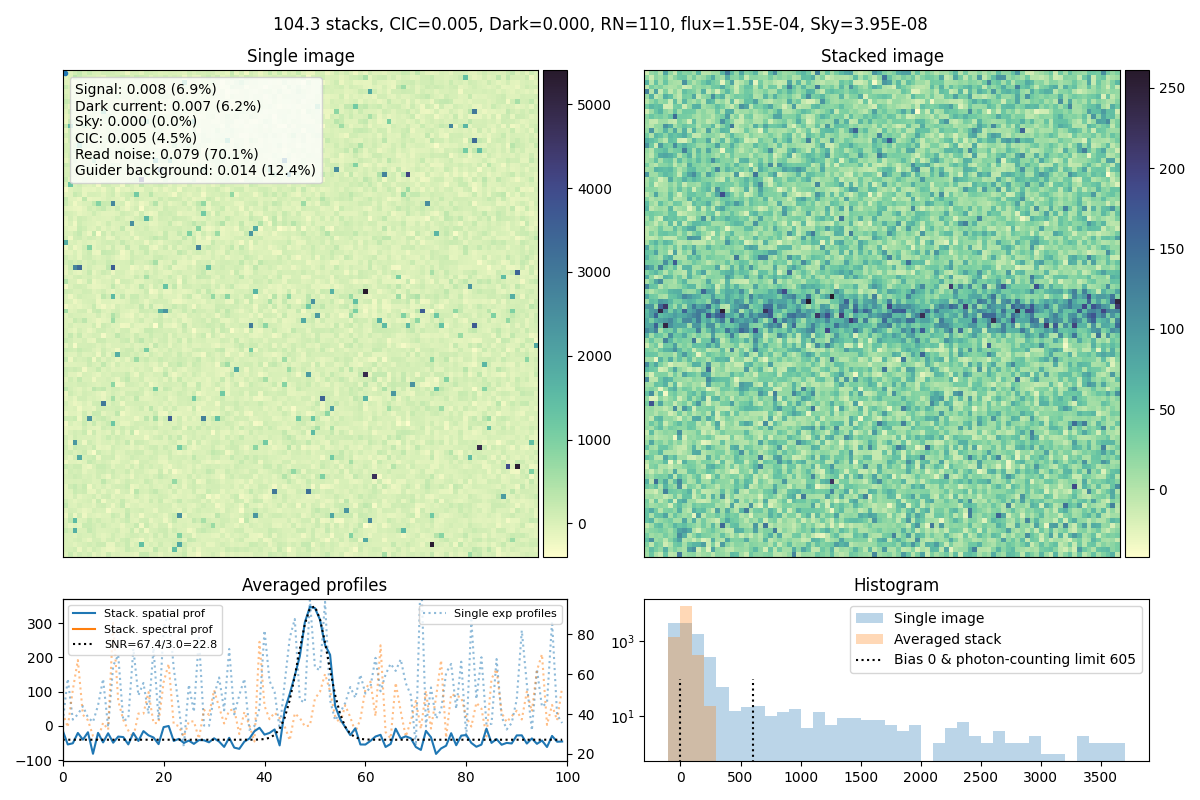

In [4]:
# %matplotlib widget
# %reload_ext autoreload

# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
# from IPython.display import display, clear_output
# import ipywidgets as widgets
# import matplotlib.pyplot as plt
# import numpy as np
# import inspect
# from astropy.io import fits
# import numpy as np
# import matplotlib.pyplot as plt
# from functools import wraps
# import inspect
# from scipy.sparse import dia_matrix
# from scipy.interpolate import interpn
# # plt.style.use('dark_background')
# import functools
# from scipy.optimize import curve_fit
# np.seterr(invalid='ignore')
# #%% 
# from tools_etc import SimulateFIREBallemCCDImage

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# np.seterr(invalid='ignore')
# import matplotlib
# from matplotlib.colors import LogNorm
# # from pyds9plugin.DS9Utils import PlotFit1D

# import math as mt
# import cmocean

# def mostFrequent(arr):
#     n=len(arr)
#     # Insert all elements in Hash.
#     Hash = dict()
#     for i in range(n):
#         if arr[i] in Hash.keys():
#             Hash[arr[i]] += 1
#         else:
#             Hash[arr[i]] = 1
 
#     # find the max frequency
#     max_count = 0
#     res = -1
#     for i in Hash:
#         if (max_count < Hash[i]):
#             res = i
#             max_count = Hash[i]
         
#     return res

# gaus = lambda x, a, xo, sigma, offset: a ** 2 * np.exp(-np.square((x - xo) / sigma) / 2)+ offset

# class Image(widgets.HBox):
     
#     def __init__(self, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='Spectra m=17.5',counting_mode=False,smearing=0.7,guider_noise=0,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,threshold=5.5):
#         super().__init__()
#         self.output = widgets.Output()
#         self.guider_noise=guider_noise
#         self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']

#         args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())

#         new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=self.guider_noise,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec)
#         sky = np.unique(new.sky)[0]/exposure_time
#         flux = np.unique(new.Signal_el)/exposure_time
#         self.im,self.im_stack, self.cube_stack, self.im0 = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source=x_axis, Rx=PSF_RMS_det, Ry=PSF_RMS_det, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(new.N_images_true))
#         # self.im0,self.im_stack,self.im = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source='fesc=10%, slit=100mu, w=204', Rx=5, Ry=5, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(new.N_images_true))
#         # self.im_stack=self.im_stack/self.im
#         self.current_cmap = cmocean.cm.deep# current_cmap = cmocean.cm.solar# self.current_cmap = cmocean.cm.thermal
        

#         self.current_cmap.set_bad(color='black')
#         # current_cmap.set_bad(color='black')
# #         self.im = SimulateFIREBallemCCDImage()[0]
#         self.bins=100#np.arange(-100,10000,10)
#         self.bins=np.arange(-100,4000,100)
        
#         self.mod = mostFrequent(self.cube_stack[:,:20,:].flatten())
#         self.limit = self.mod+threshold*RN


#         self.fig, ((self.ax,self.ax0),(self.ax1,self.ax2))  = plt.subplots(2,2,figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})#Nominal.PlotNoise()

#         if counting_mode:
#             stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
#             im0 = self.ax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
#         else:
#             im0 = self.ax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)

#         # import matplotlib.gridspec as gridspec
#         # self.fig =  plt.figure(figsize=(12,8))
#         # gs = self.fig.add_gridspec(3, 11)
#         # self.ax  = self.fig.add_subplot(gs[:2, :5])
#         # self.ax0 = self.fig.add_subplot(gs[:2, 5:10])
#         # self.ax1 = self.fig.add_subplot(gs[2:, :5])
#         # self.ax2 = self.fig.add_subplot(gs[2:, 5:10])
#         # self.ax3 = self.fig.add_subplot(gs[:, 10])
#         # self.ax3.stackplot([1,2],new.electrons_per_pix[:2,:].T,alpha=0.7,colors=self.colors)
#         im = self.ax.imshow(self.im, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
#         labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]
#         self.ax.plot(0,0,".",label="\n".join(labels))
#         self.ax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0)
#         # self.ax.text(0,0,"\n".join(labels))
#         im2=self.ax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
#         self.ax0.get_xaxis().set_ticks([])
#         self.ax0.get_yaxis().set_ticks([])
#         self.ax.get_xaxis().set_ticks([])
#         self.ax.get_yaxis().set_ticks([])
#         self.ax.set_title('Single image')
#         self.ax0.set_title('Stacked image')
#         self.ax1.set_title('Averaged profiles')
#         self.ax2.set_title('Histogram')
#         self.l1 = self.ax1.plot(self.im[:,45:-45].mean(axis=1),':',label='Single exp profiles',alpha=0.5)
#         self.l2 = self.ax1.plot(self.im[40:-40,:].mean(axis=0),':',alpha=0.5)
#         self.ax1bis = self.ax1.twinx()



#         if "Spectra" not in x_axis:
#             self.fig.axes[2].lines[0].set_ydata(self.im[:,45:-45].mean(axis=1))
#             self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
#             self.fig.axes[2].lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
#             self.l1_s = self.ax1bis.plot(self.profile,label='Stack. spatial prof',c=self.l1[0].get_color())
#             self.l2_s = self.ax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof',c=self.l2[0].get_color())
            
#         else:
#             spatial_profile = self.im[:,:].mean(axis=1)
#             self.fig.axes[2].lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
#             self.profile = np.mean(im0.get_array().data[:,:],axis=1)
#             self.l1_s = self.ax1bis.plot(self.profile,label='Stack. spatial prof',c=self.l1[0].get_color())
#             self.l2_s = self.ax1bis.plot(np.nan*self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof',c=self.l2[0].get_color())
     
#         self.popt, self.pcov = curve_fit(gaus,np.arange(len(self.profile)),self.profile,p0=[self.profile.ptp(), 50, 5, self.profile.min()])

#         # self.fit = PlotFit1D(x= np.arange(len(self.profile)),y=self.profile,deg="gaus", plot_=False,ax=self.ax1bis,c="k",ls=":",P0=[self.profile.ptp(), 50, 5, self.profile.min()])
#         self.ax1bis.plot( np.arange(len(self.profile)),gaus( np.arange(len(self.profile)),*self.popt),":k",label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))

#         self.ax1.set_xlim((0,100))
#         self.ax1.legend(loc='upper right',fontsize=8)
#         self.ax1bis.legend(loc='upper left',fontsize=8)
#         self.ax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
#         self.ax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
#         self.ax2.plot([self.mod,self.mod],[0,100],c="k",ls=":",label="Bias %i & photon-counting limit %i"%(self.mod,self.limit))
#         self.ax2.plot([self.limit,self.limit],[0,100],c="k",ls=":")
#         self.ax2.legend(loc='upper right')
#         self.ax2.set_xlim(xmax=self.bins.max())
#         self.cax = make_axes_locatable(self.ax).append_axes('right', size='5%', pad=0.05)
#         self.cax0 = make_axes_locatable(self.ax0).append_axes('right', size='5%', pad=0.05)
#         self.fig.colorbar(im, cax=self.cax, orientation='vertical')
#         self.fig.colorbar(im2, cax=self.cax0, orientation='vertical')
#         self.fig.canvas.toolbar_position = 'bottom'

#         title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, flux=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,flux,sky)

#         self.fig.suptitle(title)

#         self.fig.tight_layout()
#         style={}
#         width = '400px'
#         continuous_update=False

#         self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Description', layout=Layout(width="40px"))

#         self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)',continuous_update=continuous_update,description_tooltip="Single frame exposure time in seconds")
#         self.acquisition_time = widgets.FloatSlider( min=0.02, max=8,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',continuous_update=continuous_update,description_tooltip="Total acquisition time in hours")
#         self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',continuous_update=continuous_update,description_tooltip="Level of sky background illumination in line units")
#         # self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=10**Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',description_tooltip="Level of sky background illumination in line units")

# #         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
#         self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 2.22e-14), ('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux')

#         self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',continuous_update=continuous_update,description_tooltip="EMCCD amplification gain in e-/e-")
#         self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,description_tooltip="EMCCD readout noise in electrons")
#         self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,description_tooltip="EMCCD spurious charges due to amplification in electrons")
#         self.Dard_current = widgets.FloatSlider( min=0, max=2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,description_tooltip="Dark current of the EMCCD in electrons per hour")
#         self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,description_tooltip="Readout time of the EMCCD controller in seconds")
#         # self.x_axis=widgets.Dropdown(options=["Flat-field","Dirac","Spectra","Slit","galaxy"],value="galaxy",description='Field')
#         self.x_axis=widgets.Dropdown(options=['Spectra m=17.5','fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra m=7','Spectra m=10','Spectra m=12','Spectra m=15','Spectra m=15','Spectra m=16','Spectra m=17','Spectra m=17.5','Spectra m=18','Spectra m=19','Spectra m=20','Spectra m=22','Spectra m=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)


#         self.fwhm = widgets.FloatRangeSlider( min=1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',description_tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
#         self.QE = widgets.FloatSlider( min=0.1, max=1,value=new.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',description_tooltip="EMCCD quantum efficiency in percents")
#         self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',description_tooltip="Guider induced background level in electrons per hour")

#         self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,description_tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.")
#         # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

#         def reset(_):
#             for name in ["exposure_time","acquisition_time","Sky_LU","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","guider_noise","QE"]:
#                 rsetattr(self, '%s.value'%(name), locals_[name]) 
#         self.reset.on_click(reset)

        
#         self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width=width),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,description_tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
#         self.Signal.layout.visibility = 'hidden'
#         self.threshold.layout.visibility ='hidden'
#         # self.counting_mode.layout.visibility = 'hidden'
#         self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
# #         self.smearing.layout.visibility = 'hidden'
    

# #,self.Signal
        
#         # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
#         wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,fwhm = self.fwhm,QE=self.QE, guider_noise=self.guider_noise,threshold=self.threshold)
#         controls = VBox([HBox([self.x_axis,self.threshold,self.counting_mode,self.reset]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) , HBox([self.fwhm, self.guider_noise, self.QE])] )
#         display(HBox([self.output,controls]))

        


#     def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,fwhm,QE,guider_noise,threshold,cosmic_ray_loss_per_sec=0.005):
#         """Draw line in plot"""
#         from tools_etc import SimulateFIREBallemCCDImage


#         with self.output:
#             args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
# #             self.fig.suptitle('pompo,')
# #             title='Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix)
# #             value = locals_[x_axis]
#             if "Spectra" in x_axis:
#                 Signal = float(x_axis.split("=")[-1])
#             if counting_mode:
#                 self.threshold.layout.visibility = 'visible'
#             else:
#                 self.threshold.layout.visibility = 'hidden'
#             new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=guider_noise)#,i=arg)
#             labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(new.names)]

#             self.ax.lines[0].set_label("  \n".join(labels))
#             self.ax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0)
#             sky = np.unique(new.sky)[0]/exposure_time
#             flux = np.unique(new.Signal_el)/exposure_time

#             self.im,self.im_stack, self.cube_stack,self.im0  =  SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+guider_noise)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, sky=sky, source=x_axis, Rx=fwhm[-1], Ry=5, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(new.N_images_true),readout_time=readout_time)            


#             im = self.ax.imshow(self.im, aspect="auto",cmap=self.current_cmap)
#             self.mod = mostFrequent(self.im_stack[:20,:].flatten())
#             self.limit = self.mod+threshold*RN

#             if counting_mode:
#                 stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
#                 im0 = self.ax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
#             else:
#                 im0 = self.ax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)
#             self.fig.colorbar(im, cax=self.cax, orientation='vertical')
#             self.fig.colorbar(im0, cax=self.cax0, orientation='vertical')

#             if "Spectra" not in x_axis:
#                 self.fig.axes[2].lines[0].set_ydata(self.im[:,45:-45].mean(axis=1))
#                 stacked_profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
#                 self.fig.axes[2].lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
#                 self.ax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                 
#             else:
#                 # print(x_axis)
#                 spatial_profile = self.im[:,:].mean(axis=1)
#                 self.fig.axes[2].lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
#                 stacked_profile = np.mean(im0.get_array().data[:,:],axis=1)
#                 self.ax1bis.lines[1].set_ydata(np.nan *  np.mean(im0.get_array().data[40:-40,:],axis=0))
#                 self.fig.axes[2].lines[1].set_ydata(np.nan * self.im[40:-40,:].mean(axis=0)) 
#             self.popt, self.pcov = curve_fit(gaus,np.arange(len(stacked_profile)),stacked_profile,p0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
#             # self.fit = PlotFit1D(x= np.arange(len(stacked_profile)),y=stacked_profile,deg="gaus", plot_=False,ax=self.ax1bis,c="k",ls=":",P0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
#             self.ax1bis.lines[0].set_ydata(stacked_profile)
#             self.SNR = self.popt[0]**2/stacked_profile[:20].std()
#             self.Flux_ADU =  np.sum(gaus( np.arange(len(stacked_profile)),*self.popt)-self.popt[-1]) 
#             # self.Flux_ADU_counting =  np.sum(-np.log(1-( self.fit["function"]( np.arange(len(stacked_profile)),*self.fit["popt"])-self.fit["popt"][-1] )/(np.exp(-threshold*RN/EM_gain))))
#             self.e_s_pix = self.Flux_ADU * new.dispersion / exposure_time / new.N_images_true  if counting_mode else  self.Flux_ADU * new.dispersion / EM_gain / exposure_time
#             self.flux = self.e_s_pix / new.Throughput/ new.Atmosphere / QE / new.area
#             photon_energy_erg = 9.93e-12
#             self.mag = -2.5*np.log10(self.flux*photon_energy_erg/(2.06*1E-16))+20.08
#             self.ax1bis.lines[2].set_label("SNR=%0.1f, mag=%0.1f"%(self.SNR ,self.mag))
#             self.ax1bis.lines[2].set_ydata(gaus( np.arange(len(stacked_profile)),*self.popt))

#             self.ax1bis.legend(loc="upper left",fontsize=8)

#             self.fig.axes[2].relim()
#             self.fig.axes[2].autoscale_view()
#             self.ax1bis.relim()
#             self.ax1bis.autoscale_view()

#             self.fig.axes[3].patches.clear()
#             self.fig.axes[3].hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
#             self.fig.axes[3].hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
#             self.fig.axes[3].legend(loc='upper right',fontsize=8)
#             self.ax2.lines[0].set_xdata([self.mod,self.mod])
#             self.ax2.lines[1].set_xdata([self.limit,self.limit])
#             self.ax2.lines[0].set_label("Bias %i & photon-counting limit %i"%(self.mod,self.limit))
#             self.ax2.legend(fontsize=8,loc="upper right")
#             title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, Flux=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,flux,sky)
#             self.fig.suptitle(title)
#             self.fig.canvas.draw()

# # ETC = Image(EM_gain=2000,RN=60, smearing=0.4,Dard_current=1,counting_mode=False,Sky_LU=4.5,guider_noise=0.5,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55)
 
# # 2018
# ETC = Image(EM_gain=1400,RN=110, smearing=0.8,Dard_current=0.5,counting_mode=False,Sky_LU=5.5,guider_noise=1,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55)


<!-- # <center>FIREBall-2 SNR calculator </center>

### Explanation
- Gives the estimated signal-to-noise ratio for an extended source on a resolution element
- **Variables:** Source's flux, sky, aquisition time, exposure time, EM gain, dark current, CIC, readnoise, readout time, thresholding, smearing exponential length and temperature if you check it (based on a first rough evolution of smearing and dark current with temperature, therefore changing the temperature will change smearing and dark accordingly.)
- **Fixed Values:** QE = 45%, resolution element=57 mu, pixel_size = 13 mu, throughput = 13%, atmosphere transmission = 50%
- **Outputs:** In the top pannel, the noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. The middle pannel we give the average e-/pix value for each component (before stacking). We give the relative fraction of all sources of noise and the resulting SNR. When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
- **Caution:**  it appears that for EMCCDs the dependencies are pretty complex/non-linear. In particular, the lack of models on the impact of amplification, thresholding, and register clearing... combined with smearing on the final SNR makes risky the fact of relying only on modeling to choose the optimal temperature/gain/etc. That's why I suggest an [end-to-end test](https://docs.google.com/document/d/1SpiEK8MBmYduKUFvWmnTOfkfsX4VWs6JMF5-YJKDELo/edit?usp=sharing) validating this: 


### Analysis
- **Smearing:** At -120C, the low device's CTE smears the pixels' counts and then lowers the effective gain. This lowering factor is huge (>2) for a smearing length of 1.5, but is much smaller for a smearing length of 0.7 (~1.2). 
It seems that we already had a comparabale 0.7 smearing length with previous controller at 10MHz (tests February 7th and 8th 2019) at same EMgain (1600) and temperature (-95C). Which might mean that the 1MHz reading does not decrease significantly the smearing. **With the current (2022) smearing length, thresholding does not increase the SNR!! If we manage to invert the smearing, even if it doubles the readnoise, we could recover most of the thresholding efficiency.**
- **Photon-counting:** The thresholding effect can be misleading as it depends on Flux, EMgain, RN, smearing and noise($\sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$). But actually it depends mostly on the ratio $\frac{G_{EM,eff}}{RN}$. For a ratio >> 10 the thresholding is efficient. As stated above for a smearing length of 0.7, EMgain and effective_gain are close. A consequence of that, is that at the EMgains we use ($\sim1600$) and smearing $\sim 0.7$, the thresholding is almost as efficient with RN=50 and RN=107 as the ratio $\frac{G_{EM,eff}}{RN}$ stays >>10. This was not the case in 2018 when the smearing length was 1.5. This is why in photon counting mode, you will see a very small impact of read noise change.
- **Reading frequency tradeoff:** Based on above, the change from 10MHz to 1MHz as minor consequences on the total SNR.
    - In photon counting mode and with low smearing, the decrease of the RN has quasi no effect (~1%) on the SNR
    - The transition from 1.4 to 3sec readout would mean a loss of SNR of ~2%, transition to 10sec about ~10% 
    - Therefore the real critical point is the possible need to add or not a shutter above the tank with the 1MHz controller as it will complexify guidance
- **Temperature Tradeoff:** Conclusion depends on the definition of SNR on thresholded images (see below): In both cases, the SNR decreases with smearing but in one case smearing has more important impact and compensate  dark current giving rise to an optimal temperature. Though, the fact that we will never get rid of dark current while we could actually manage to inverse the smearing could suggest staying at low temperature (-120 to -110).

 
  
  
|             **Parameters**             |          **2022 1Mhz controller**           | **Values 2018** |
| :------------------------------------: | :-----------------------------------------: | :-------------: |
|          **Temperature (C)**           |                     -95                     |      -115       |
|       **Conversion gain ADU/e-**       |                    1/4.5                    |      0.53       |
|           **Read noise e-**            |            50 -> 60 longer cable            |       107       |
|         **pCIC e− /pix/frame**         |                    0.003                    |      0.004      |
|         **sCIC e− /pix/frame**         |                   ~0.002                    |     ~0.002      |
|  **semi-amplified CIC e− /pix/frame**  |                    ~0.02                    |     ~0.03-4     |
|           **EM gain  e-/e-**           |          O                    2000          |      1400       |
|   **Smearing exponent. length pix**    |              L~0.6 ± 0.1  pix               |   L~1.5 ± 0.1   |
|       **Dark current e− /pix/h**       |                   ~2±0.5                    |   0.5 ± 0.03    |
| **Cosmetics % pixels bottom detector** |                     ~2%                     |   <<1% (TBD)    |
|         **Exposure time sec**          |                     50                      |       50        |
|          **Readout time sec**          | ~10 (all), ~3(physical) +2 better clearance |      ~1.4       |


<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->

<!-- Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decrease of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600). For very bright objects the shot noise becomes dominant and then the impact of dark current is smaller so the SNR peaks at higher temps (80).
 --> 

<!-- 
## Thresholding analysis
The threshold is computed by optimizing the SNR:

$$ SNR_1(T) = F_{True,pos}(T)\frac{S \times F_{e^->0,ADU>T}}{\sqrt{ F_{e^->0,ADU>T} \times(S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2)  + F_{e^-=0,ADU>T} \frac{\sigma_{RN}^2}{Gain} }} 
\sim F_{True,pos}(T) \frac{S \sqrt{ F_{e^->0,ADU>T}}}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2 }}$$



with:
- $\sigma_{RN}^2=\frac{RN}{G_{EM}} \times \frac{\sum RN[RN>T]}{\sum RN} = \frac{RN}{EMgain}  \times \%pix_{e^-=0}^{ADU>T}$: ie 60e-/2000 x the fraction of pixels above the threshold which dit not receive any photo-electrons 
- $ F_{e^->0,ADU>T}$ :  fraction of pixels above the threshold which received more than 0 electons
- $ F_{e^-=0,ADU>T}$ :  fraction of pixels above the threshold which did not receive any electron
- $F_{True,pos} = \frac{F_{e^->0,ADU>T}}{F_{ADU>T}} $ : the fraction of true positives = the fraction of pixels above the threshold which received more than 0 electons. This uncertainty term is not in the final SNR formula as it converges towards ~1 after stacking as the average pixel value will converge towards the real number of incoming photo-electrons

The thresholding depends on 5 factors:
- **The gain**: the higher the gain the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The read noise**: the lower the RN the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The low CTE** smears the charges, from pixels who did receive a photo-electron to pixel who did not and lower the effective gain $G_{EM,eff}$
- **The signal**: because thresholding only allows to recover 0 and 1, thresholding is only efficient at flux <<1e-/exp 
- **The additional noise**: $\sigma = \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$ has relatively small impact on the impact of the thresholding

**At the end, the thresholding impact is:**
- Highly non linear, many things to learn
- The efficiency of the thresholding depends mostly of the ratio $\frac{G_{EM,eff}}{RN}$, which extremely impacted by the smearing.
- The thresholding SNR gain (SNR$_{threshold}$/SNR$_{analogic}$) lies within $[0,\sqrt{2}]$. Condditions are pretty stricts to get som thresholding efficiency and smearing makes the upper bound falls dramatically. 
- Therefore if might not worth it to loose SNR in order to be in these very conditions as we will loose it anyway in the final budget.
- The thresholding SNR gain seems less impacted by read noise. Which means that if we manage to do some (linear?) inversion of the smearing which increases the noise, it might still increase the thresholding gain above 1. 
- The only real game changer in terms of SNR is the smearing 
- **Fraction kept (photo-electrons above threshold)**
    - Important dependance on smearing and flux, less important one on gain and read noise.
    - At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept.
    - Evolution with smearing is dramatic, higher gain does not help much, lower RN helps
    - Fraction increase with flux 
- **Fraction fake detections (0e- pixels above threshold)**
    - Increases importantly with smearing
    - does not depend much on read noise (small positive correlation)
    - decreases with gain
    - Increases as Flux increase. Not sure to understand why... Maybe because the number of pixels with 0 photo-e- cecreases 
- **Thresholding SNR gain**
    - Thresholding is efficient only if >1
    - Dramatically decreases with smearing (No interest of thrsholding above smearing legth of 0.6)
    - Increases with gain and decreases with read noise if no smearing
    - if smearing, the read noise has no impact.
    - Increases with flux
- **Threshold**
    - increase extremely with smearing
    - Without smearing, poor dependance on gain and readnoise
    - If smearing, increases as readnoise decreases
    - If smearing: Increasing with gain!
    - Increases with flux

 -->

<!-- 

|   **Thresholding dependancy table**                   | **Smearing <br />  ( 0 - 2 )** | **Read noise  <br /> ( 30 - 120 )** | **Gain  <br /> ( 800 - 2500 )** | **Flux <br /> ( 0.01 - 1.5 )** |
|:--------------------:|:------------------:|:-----------------------:|:-------------------:|:------------------:|
|     **Photo-electron Fraction kept**    |    --- <br /> 92% - 66%    |       -  <br /> 72% - 71%       |     .   <br /> 72% - 71%    |     +  <br /> 75% - 76%    |
| **RN fraction kept** |  +++  <br /> 0.6% - 12.4%  |       +  <br /> 0.7% - 1%       |    -  <br /> 1.1% - 0.5%    |    ++?  <br /> 0.3% - 3%   |
|     **Threshold**    |   +++  <br /> 3 σ - 11 σ   |      --  <br /> 18 σ - 5 σ      |     + <br />  5 σ - 16 σ    |    +? <br />  8 σ - 13 σ    |
|        **Thresholding SNR gain**       |     --- <br />  1.3 - 0.6   |        --  <br /> 1.35 - 1.22        |      +  <br /> 1.13 - 1.18      |      ++  <br /> 1.16 - 1.21     |
 -->
